In [3]:
import numpy as np
W = np.arange(21).reshape(7, 3)
W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [2]:
W[2]

array([6, 7, 8])

In [17]:
idx = np.array([1, 3, 0, 1])
W[idx] # 여러 행을 한꺼번에 추출

array([[ 3,  4,  5],
       [ 9, 10, 11],
       [ 0,  1,  2],
       [ 3,  4,  5]])

In [4]:
class Embedding:
    def __init__(self, W):
        self.params = [W] # list
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx): # np.array
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

In [19]:
emb = Embedding(W)
emb.forward(idx)

array([[ 3,  4,  5],
       [ 9, 10, 11],
       [ 0,  1,  2],
       [ 3,  4,  5]])

In [23]:
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0 # 0으로 덮어 씀
        dW[self.idx] = dout # 실은 나쁜 예 (기존 가중치 특정 행 갱신 가능함)
        return None

In [5]:
class Embedding:
    def __init__(self, W):
        self.params = [W] # list
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx): # np.array
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0

#       for i, word_id in enumerate(self.idx):
#           dW[word_id] += dout[i]

        np.add.at(dW, self.idx, dout) # dout를 dw의 idx 행에 더해줌 (중복 문제)

        return None

In [34]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None # 역전파 때 쓰기 위해 순전파 결과 저장(h, target_W)

    def forward(self, h, idx):
        '''
        W        : (vocab, hidden) -> 원래는 h,v 
        idx      : (#mini_batch,) -> 정답 idx 각 각
        target_W : (#mini_batch, hidden)
        h        : (#mini_batch, hidden)
        
        target_W
        * h      : (#mini_batch, hidden) -> np * -> element-wise

        out      : (hidden,)
        '''
               
        target_W = self.embed.forward(idx) 
        out = np.sum(target_W * h, axis=1) # dot product
                                           # * 연산하면 shape 안맞춰줘도 돼서 편함
                                           # 어차피 (h,)*(h,)
        self.cache = (h, target_W)
        return out
                                           
    def backward(self, dout): # sigmoid with loss (batch,)
        # 그냥 흘려보내면 된다.
        h, target_W = self.cache        
        # dout = (batch,) -> 행렬 곱 수행 위해 reshape
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h # (batch,1) * (batch, hidden)
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh        

In [31]:
W = np.arange(18).reshape(6, 3)

In [29]:
idx = np.array([1, 3, 0, 2 ,4 ,1])
embed = Embedding(W)
target_W = embed.forward(idx)

In [30]:
embDot = EmbeddingDot(W)
h = np.array([[0.0011865, 0.00054727, -0.00350523],
 [ 0.0080607,  0.00873808, -0.00930809],
 [ 0.00719375 ,-0.00618628,  0.00065774],
 [ 0.00806074 , 0.00873808 ,-0.00930809],
 [-0.00048219,-0.00481416, -0.00305934],
 [ 0.00745012, -0.00218385 ,-0.00796147]])
embDot.forward(h, idx)
#print(target_W)
#print(target_W * h)
#print(out)

[[ 3  4  5]
 [ 9 10 11]
 [ 0  1  2]
 [ 6  7  8]
 [12 13 14]
 [ 3  4  5]]


[[ 0.0035595   0.00218908 -0.01752615]
 [ 0.0725463   0.0873808  -0.10238899]
 [ 0.         -0.00618628  0.00131548]
 [ 0.04836444  0.06116656 -0.07446472]
 [-0.00578628 -0.06258408 -0.04283076]
 [ 0.02235036 -0.0087354  -0.03980735]]


[-0.01177757  0.05753811 -0.0048708   0.03506628 -0.11120112 -0.02619239]


In [35]:
dout = np.random.randn(6)
dout * h

ValueError: operands could not be broadcast together with shapes (6,) (6,3) 

In [36]:
dout = np.random.randn(6)
dout = dout.reshape(dout.shape[0], 1)
dout * h

array([[-0.00120147, -0.00055417,  0.00354946],
       [-0.00120087, -0.00130178,  0.0013867 ],
       [-0.0026712 ,  0.0022971 , -0.00024423],
       [ 0.0024513 ,  0.00265729, -0.00283063],
       [ 0.00029956,  0.00299074,  0.00190058],
       [-0.00189828,  0.00055644,  0.00202857]])

In [55]:
# np.random.choice()
words = ['you', 'say', 'goodbye', 'I', 'hello', '.']
print(np.random.choice(words))
print(np.random.choice(words, size=5)) # 중복 있음
print(np.random.choice(words, size=5, replace=False)) # 중복 없음

# 확률분포에 따라
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1] # 합 1이어야 함!!
print(np.random.choice(words, p=p)) # 분포 높으면 많이 추출

say
['I' 'say' '.' 'I' 'you']
['hello' 'goodbye' 'you' 'say' '.']
you


In [45]:
print(np.random.choice(words, size=2))

['hello' 'goodbye']


In [57]:
p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)
print(new_p)

[0.64196878 0.33150408 0.02652714]


In [ ]:
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size) # (단어ID목록, 확률분포에제곱, 샘플링횟수)
target = np.array([1, 3, 0]) # positive 3개 미니배치
negative_sample = sampler.get_negative_sample(target)
print(negative_sample) # 각각 1/3/0 이 아닌 negative
# [[0 3]
#  [1 2]
#  [2 3]]

In [3]:
import collections
counts = collections.Counter()
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
for word_id in corpus:
    counts[word_id] += 1 # 중복되면 해당 id의 value 값 2
    vocab_size = len(counts) # vocab_size지!!
print(vocab_size)

5


In [6]:
import sys
sys.path.append('..')
from common import layers
from negative_sampling_layer import UnigramSampler

class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        # sampling 준비
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)

        # layers : 긍정적 예를 다루는 계층 + sample_size만큼 부정적 예를 다루는 계층!!
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)] # 샘플+1 개의 layers
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        # params
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target):
        # 네거티브 샘플링 -> 학습
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32) # 긍정적 예의 정답 레이블은 1!!
        loss = self.loss_layers[0].forward(score, correct_label)

        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32) # 부정적 예의 정답 레이블은 0!!
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i] # sample_size가 2면 [[0 3], [2 3] ...]
            # layer[0] 은 긍정적 예꺼임!
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore) # Embedding.dot, 순전파 시 긍정적 예 + 부정적 예 복사됐었음 (repeat 노드)

        return dh

In [2]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import Embedding
from ch04.negative_sampling_layer import NegativeSamplingLoss

class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 1. 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H) # 임베딩 벡터 row 방향 배치 (embedding 계층 쓸라고)
        
        # 2. 계층 생성 : embedding(w_in) -> negativesamplingloss(embedding, w_out & loss)
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5) # corpus, unigramsampler에서 vocab 만듦

        # 3. 모든 가중치와 기울기를 배열에 모으기
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # 4. 인스턴스 변수에 단어 분산 표현 저장
        self.words_vecs = W_in

    def forward(self, contexts, target): # contexts 2d, target 1d
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:,i]) # 첫번째 타겟부터 순서대로~
        h *= 1 / len(self.in_layers) # 평균!!!
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None


| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 2[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 4[s] | 손실 4.12
| 에폭 1 |  반복 81 / 9295 | 시간 5[s] | 손실 4.05
| 에폭 1 |  반복 101 / 9295 | 시간 6[s] | 손실 3.93
| 에폭 1 |  반복 121 / 9295 | 시간 8[s] | 손실 3.77
| 에폭 1 |  반복 141 / 9295 | 시간 9[s] | 손실 3.63
| 에폭 1 |  반복 161 / 9295 | 시간 11[s] | 손실 3.49
| 에폭 1 |  반복 181 / 9295 | 시간 13[s] | 손실 3.35
| 에폭 1 |  반복 201 / 9295 | 시간 14[s] | 손실 3.26
| 에폭 1 |  반복 221 / 9295 | 시간 15[s] | 손실 3.17
| 에폭 1 |  반복 241 / 9295 | 시간 17[s] | 손실 3.08
| 에폭 1 |  반복 261 / 9295 | 시간 19[s] | 손실 3.02
| 에폭 1 |  반복 281 / 9295 | 시간 20[s] | 손실 2.96
| 에폭 1 |  반복 301 / 9295 | 시간 22[s] | 손실 2.93
| 에폭 1 |  반복 321 / 9295 | 시간 25[s] | 손실 2.86
| 에폭 1 |  반복 341 / 9295 | 시간 30[s] | 손실 2.84
| 에폭 1 |  반복 361 / 9295 | 시간 33[s] | 손실 2.82
| 에폭 1 |  반복 381 / 9295 | 시간 36[s] | 손실 2.80
| 에폭 1 |  반복 401 / 9295 | 시간 39[s] | 손실 2.75
| 에폭 1 |  반복 421 / 9295 | 시간 41[s] | 손실 2.75
| 에폭 1 |  반복 441 / 9295 

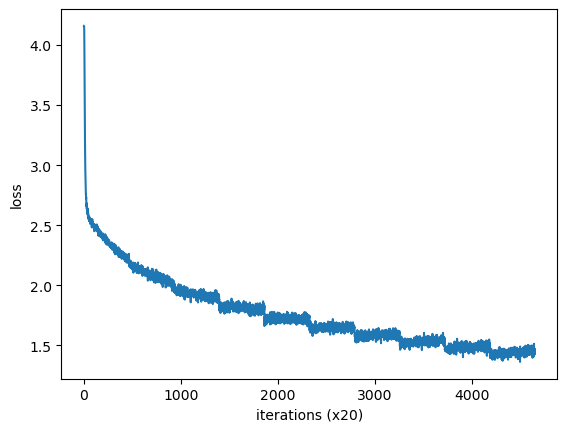

In [2]:
import sys
sys.path.append('..')
import numpy as np
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from cbow import CBOW
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb
from common import config # GPU = False
##config.GPU = True
import time

# 1. 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 2. 데이터 읽기 & contexts,target 생성
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# 3. 모델, 옵티마이저 생성 -> trainer 객체 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 4. 학습 시작
start = time.time()
trainer.fit(contexts, target, max_epoch, batch_size)
end = time.time()
print(f'걸린 시간 : {(end - start)}')
trainer.plot()

# 5. 필요한 데이터 저장 (나중에 사용 가능케) : 워드벡터, 파라미터 {} -> 피클
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

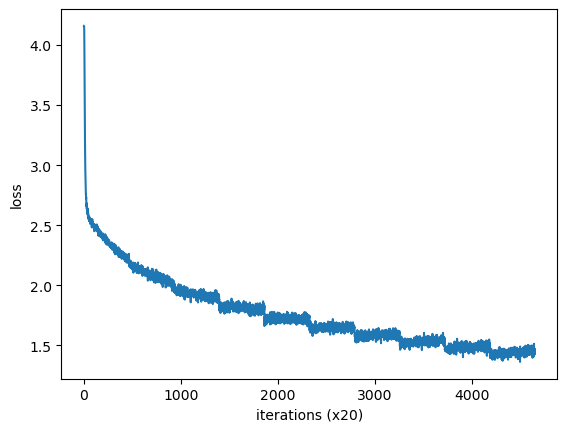

In [3]:
trainer.plot()

In [ ]:
import sys
sys.path.append('..')
from common.util import most_similar
import pickle

pkl_file = 'cbow_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

In [ ]:
from common.util import analogy, normalize

analogy('king', 'man', 'queen', word_to_id, id_to_word, word_vecs) # 데이터셋 안에 있는 단어들
analogy('take', 'took', 'go', word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child', word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad', word_to_id, id_to_word, word_vecs)